# Analysis & Modeling Pipeline for Diet–Diabetes Classification (ENSIN 2005)

This notebook implements the analysis and modeling stage of our study on the association between dietary patterns/nutrient intake and self-reported type 2 diabetes in Colombian adults using ENSIN 2005. Building on the cleaned, harmonized dataset prepared in the preprocessing notebook, we train and compare multiple classifiers (logistic regression, Random Forest, XGBoost, LightGBM, CatBoost, KNN) and a soft-voting ensemble under stratified cross-validation. We examine class-imbalance strategies (no resampling vs. SMOTE) and apply probability calibration (Platt/Isotonic), reporting ROC-AUC, PR-AUC, F1, and Brier score. Finally, we provide model explainability with SHAP (global and individual levels) and run sensitivity checks across feature sets and random seeds.

## Step 1 – Data Loading and Initial Cleaning

We load two input datasets: FoodDataset.csv (dietary group structure) and NutrientsDataset.csv (nutrient composition).

In [1]:
import pandas as pd

## Load raw datasets from  input directory.
## Note: NutrientsDataset uses comma as decimal separator, so we set decimal=",".
try:
    EN2005a = pd.read_csv(
        "/kaggle/input/diabetesdocs/FoodDataset.csv", ## Change the path
        delimiter=";",
        low_memory=False,
        encoding="utf-8",
        on_bad_lines="warn"  # prevent failure on malformed rows
    )
    EN2005c = pd.read_csv(
        "/kaggle/input/diabetesdocs/NutrientsDataset.csv", ## Change the path
        delimiter=";",
        decimal=",",
        low_memory=False,
        encoding="latin1",
        on_bad_lines="warn"
    )
    print("Files loaded successfully.")
except FileNotFoundError as e:
    ## Explicit error message for debugging if filenames or paths change
    print("One or more input files were not found:", e)
    raise

## Data cleaning step: drop the second column of EN2005c if it exists
if EN2005c.shape[1] > 1:
    EN2005c = EN2005c.drop(EN2005c.columns[0], axis=1)

## Optional: remove trailing spaces from column names to avoid merge issues later
EN2005a.columns = EN2005a.columns.str.strip()
EN2005c.columns = EN2005c.columns.str.strip()

Files loaded successfully.


We drop selected nutrient and %RDA variables identified as highly correlated with others, reducing redundancy in the dataset before modeling.

In [2]:
import pandas as pd

## Remove specific columns after evaluating high correlation with other variables
columns_to_drop = [
    "Calcium %RDA", "Folic Acid %RDA", "Vitamin A %RDA", "Vitamin C %RDA",
    "Vitamin B12 %RDA", "Fiber %RDA", "Zinc %RDA", "Protein %RDA", "Fat (g)"
]

EN2005c = EN2005c.drop(columns=columns_to_drop)
print("Highly correlated variables removed.")


Highly correlated variables removed.


In [10]:
EN2005a.head()

,Diabetes,Dairy,Grain and cereals,Oils or fats,Vegetables,Proteins,Other,Hot beverages,Sweets,Fruits,...,Processed food,Sugary beverage,Red meat,Snacks,Fruit juice,Alcoholic beverages,Supplement,Sauces,Legumes,Broths and soups
0,0,2,2,1,4,0,0,0,2,3,...,0,0,2,1,0,0,0,1,0,0
1,0,0,2,5,6,2,0,0,3,5,...,0,0,1,0,0,1,2,1,1,0
2,0,2,6,6,4,0,0,2,0,7,...,0,0,4,0,0,0,5,0,0,0
3,0,1,2,4,5,1,0,1,3,4,...,0,0,1,0,0,0,0,0,0,0
4,0,3,1,1,3,0,0,0,3,6,...,0,0,1,0,0,0,0,0,1,1


In [11]:
EN2005c.head()

,Kilocalories (kcal),Protein (g),Polyunsaturated Fat (g),Monounsaturated Fat (g),Saturated Fat (g),Carbohydrates (g),Calcium (mg),Cholesterol (mg),Crude Fiber (g),Dietary Fiber (g),...,Thiamine (mg),Vitamin B6 (mg),Folic Acid (µg),Vitamin B12 (µg),Ascorbic Acid (Vitamin C) (mg),Riboflavin (mg),Niacin (mg),Animal Protein (g),Concentrated Carbohydrates (g),Diabetes
0,2252.48,88.81,8.54,29.19,42.52,326.95,609.93,490.89,1.18,16.51,...,0.87,0.02,223.95,5.23,90.12,1.67,20.25,64.18,35.9600,0.0
1,4089.66,117.14,21.58,18.51,13.53,540.32,503.30,478.61,2.68,38.28,...,1.51,0.09,601.16,9.37,152.62,2.30,32.63,75.02,136.2900,0.0
2,1579.09,64.35,6.78,16.83,14.16,250.61,1127.08,133.26,0.35,37.57,...,31.57,40.06,412.23,2.80,525.76,11.11,116.53,36.32,0.0001,0.0
3,877.83,39.16,9.58,9.08,11.56,118.87,442.97,75.06,0.38,13.18,...,15.63,20.04,94.72,2.01,51.48,5.72,56.75,26.20,0.0001,0.0
4,1226.42,42.06,4.58,6.24,6.39,225.96,213.38,453.70,1.92,16.98,...,0.49,0.01,155.28,14.75,99.65,0.80,7.77,31.57,44.3600,0.0


## Step 2 – Missing Value Imputation
We apply IterativeImputer (MICE) to fill missing nutrient values using multivariate patterns, generating a complete dataset for further modeling.

In [3]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # needed to enable IterativeImputer
from sklearn.impute import IterativeImputer

## Impute missing values using IterativeImputer (multivariate approach)
imputer = IterativeImputer() # random
EN2005c = pd.DataFrame(imputer.fit_transform(EN2005c), columns=EN2005c.columns)

print("Missing values imputed successfully.")

Missing values imputed successfully.


## Step 3 – Class Balancing

We address the strong imbalance in the diabetes outcome variable using a two-stage strategy:

1. Oversampling (SMOTE): The minority class is synthetically expanded up to 400% of its original size.

2. Undersampling: The majority class is then randomly reduced to one third of its post-SMOTE size.

This combined approach mitigates class imbalance while preserving sufficient variability in both classes, producing the balanced dataset df_resampled5c for subsequent modeling.

In [4]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1 ## Required for online environments with compatibility issues.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 3.8 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


## Food Dataset

In [6]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

## Split features and target (assumes 'Diabetes' is the target column)
X = EN2005a.drop('Diabetes', axis=1)
y = EN2005a['Diabetes']

## Check original class distribution
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
print("Original class distribution:", class_counts.to_dict())

## Define SMOTE cap: minority class will not exceed 400% of its original size
max_minority_samples = int(class_counts[minority_class] * 4)

## SMOTE sampling strategy (only the minority class is increased)
sampling_strategy = {
    majority_class: class_counts[majority_class],
    minority_class: max_minority_samples
}

## Use a safe k_neighbors in case the minority class is very small
k_neighbors_safe = max(1, min(5, class_counts[minority_class] - 1))

## Apply SMOTE oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors_safe, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_resampled))

## Temporary DataFrame to combine features and target
df_temp = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diabetes')],
    axis=1
)

## Undersample: reduce the majority class to one third of its post-SMOTE size
majority_count_after_smote = (df_temp['Diabetes'] == majority_class).sum()
majority_count_target = int(majority_count_after_smote / 3)  # keep /3 as specified

df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
df_minority = df_temp[df_temp['Diabetes'] == minority_class]

## Concatenate and shuffle
df_resampled5a = pd.concat([df_majority, df_minority], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

## Final balanced distribution
print("Final class distribution:", df_resampled5a['Diabetes'].value_counts().to_dict())


Original class distribution: {0: 5455, 1: 289}
After SMOTE: Counter({0: 5455, 1: 1156})
Final class distribution: {0: 1818, 1: 1156}


## Nutrient Dataset

In [7]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

## Split features and target (assumes 'Diabetes' is the target column)
X = EN2005c.drop('Diabetes', axis=1)
y = EN2005c['Diabetes']

## Check original class distribution
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
print("Original class distribution:", class_counts.to_dict())

## Define SMOTE cap: minority class will not exceed 400% of its original size
max_minority_samples = int(class_counts[minority_class] * 4)

## SMOTE sampling strategy (only the minority class is increased)
sampling_strategy = {
    majority_class: class_counts[majority_class],
    minority_class: max_minority_samples
}

## Use a safe k_neighbors in case the minority class is very small
k_neighbors_safe = max(1, min(5, class_counts[minority_class] - 1))

## Apply SMOTE oversampling
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors_safe, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("After SMOTE:", Counter(y_resampled))

## Temporary DataFrame to combine features and target
df_temp = pd.concat(
    [pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diabetes')],
    axis=1
)

## Undersample: reduce the majority class to one third of its post-SMOTE size
majority_count_after_smote = (df_temp['Diabetes'] == majority_class).sum()
majority_count_target = int(majority_count_after_smote / 3)  # keep /3 as specified

df_majority = df_temp[df_temp['Diabetes'] == majority_class].sample(majority_count_target, random_state=42)
df_minority = df_temp[df_temp['Diabetes'] == minority_class]

## Concatenate and shuffle
df_resampled5c = pd.concat([df_majority, df_minority], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

## Final balanced distribution
print("Final class distribution:", df_resampled5c['Diabetes'].value_counts().to_dict())


Original class distribution: {0.0: 5714, 1.0: 298}
After SMOTE: Counter({0.0: 5714, 1.0: 1192})
Final class distribution: {0.0: 1904, 1.0: 1192}


## Step 4 – Classifier Benchmarking

Train a diverse set of classifiers (linear, tree-based, instance-based, and boosting). Split data, fit each model, predict on the test set, compute metrics (Accuracy, Precision, Recall, F1), and rank models by F1 to identify strong baselines for the calibrated ensemble stage.

In [26]:
import pandas as pd
import numpy as np
import warnings
from collections import Counter

## Silence common training warnings (e.g., convergence)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

## Models & utilities
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Gradient boosting libs (set low verbosity)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

## -------------------------
## Build classifier collection (~15) with controlled verbosity
## -------------------------
def make_classifiers():
    return {
        # Linear / margin-based (scaled)
        "Logistic Regression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42))
        ]),
        "Linear SVM": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(random_state=42))
        ]),
        "RBF SVM": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(kernel="rbf", random_state=42))
        ]),
        "SGD (Log Loss)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SGDClassifier(loss="log_loss", random_state=42))
        ]),
        "Passive-Aggressive": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", PassiveAggressiveClassifier(random_state=42))
        ]),

        # Instance-based
        "KNN": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(n_neighbors=5))
        ]),

        # Trees / ensembles
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42
        ),

        # Probabilistic
        "Gaussian NB": GaussianNB(),
        "QDA": QuadraticDiscriminantAnalysis(),

        # GBM family (silenced)
        "LightGBM": lgb.LGBMClassifier(random_state=42, n_estimators=300, verbose=-1),
        "XGBoost": xgb.XGBClassifier(
            n_estimators=300, eval_metric="logloss", random_state=42, n_jobs=-1, verbosity=0
        ),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42, iterations=300)
    }

## -------------------------
## Training/evaluation routine (quiet)
## -------------------------
def run_benchmark(df, dataset_label):
    """
    Train and evaluate a diverse set of classifiers on the provided DataFrame.
    Assumes binary target column named 'Diabetes'. Returns a sorted results DataFrame by F1.
    """
    ## Split features/target
    X = df.drop('Diabetes', axis=1)
    y = df['Diabetes']

    ## Train/test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    classifiers = make_classifiers()
    results = []

    for name, clf in classifiers.items():
        try:
            ## Fit quietly
            clf.fit(X_train, y_train)

            ## Predict labels
            y_pred = clf.predict(X_test)

            ## Confusion matrix with fixed label order (0,1)
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()

            ## Metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

            results.append([name, accuracy, precision, recall, f1, [tn, fp, fn, tp]])
        except Exception as e:
            ## Log only the model name on failure to keep output concise
            results.append([f"{name} (failed: {e.__class__.__name__})", np.nan, np.nan, np.nan, np.nan, None])

    df_results = pd.DataFrame(
        results,
        columns=["Classifier", "Accuracy", "Precision", "Recall", "F1 Score", "Confusion Matrix"]
    )
    df_sorted = df_results.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

    print(f"\n=== {dataset_label} — Model ranking by F1 ===")
    print(df_sorted)
    return df_sorted

## -------------------------
## Run for both datasets if available
## 5a = FoodDataset, 5c = NutrientDataset
## -------------------------
results_5a = None
results_5c = None

if 'df_resampled5a' in globals():
    ## FoodDataset
    results_5a = run_benchmark(df_resampled5a, "FoodDataset (df_resampled5a)")

if 'df_resampled5c' in globals():
    ## NutrientDataset
    results_5c = run_benchmark(df_resampled5c, "NutrientDataset (df_resampled5c)")


=== FoodDataset (df_resampled5a) — Model ranking by F1 ===
             Classifier  Accuracy  Precision    Recall  F1 Score  \
0               XGBoost  0.818487   0.797101  0.714286  0.753425   
1              LightGBM  0.816807   0.799020  0.705628  0.749425   
2         Random Forest  0.825210   0.846995  0.670996  0.748792   
3              CatBoost  0.796639   0.775000  0.670996  0.719258   
4                   KNN  0.752941   0.653285  0.774892  0.708911   
5         Decision Tree  0.697479   0.600000  0.662338  0.629630   
6                   QDA  0.610084   0.498708  0.835498  0.624595   
7               RBF SVM  0.714286   0.640553  0.601732  0.620536   
8           Gaussian NB  0.576471   0.474201  0.835498  0.605016   
9   Logistic Regression  0.692437   0.623711  0.523810  0.569412   
10    Gradient Boosting  0.710924   0.676647  0.489177  0.567839   
11           Linear SVM  0.692437   0.626316  0.515152  0.565321   
12       SGD (Log Loss)  0.636975   0.529183  0.588745  

## Step 5 – Hyperparameter Tuning (Top-5 Models)

This section tunes the five best classifiers identified in the benchmarking step. We run a randomized search with stratified 5-fold cross-validation using F1 as the optimization target, refit the best configuration on the training split, and evaluate on the held-out test split.

Datasets: Tuning is executed on one dataset at a time to explore each response space:

• FoodDataset (df_resampled5a) → run the full search and record best hyperparameters.

• NutrientDataset (df_resampled5c) → rerun the same grids/procedures by swapping X, y to probe nutrient-level signal.


### XGBoost - Tuning

Randomized search over n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, and min_child_weight, with 5-fold CV (scoring=F1). The base model uses eval_metric='logloss' and a fixed random_state. Refit the best estimator on the training split and report Accuracy, Precision, Recall, F1, and a 2×2 confusion matrix on the test set. Repeat the identical procedure with df_resampled5c by redefining X, y.

In [ ]:
import pandas as pd
import numpy as np
# (matplotlib / seaborn imported earlier if needed for plots)

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

## Define features (X) and target (y) from FoodDataset (df_resampled5a)
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']

## Train/test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## Hyperparameter search space for XGBoost (balanced breadth vs. cost)
param_dist = { 
    "n_estimators": np.arange(200, 500, 25),
    "max_depth": np.arange(3, 15, 3),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "subsample": np.linspace(0.5, 1.0, 5),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "gamma": np.linspace(0.0, 5.0, 5),
    "min_child_weight": np.arange(1, 10, 2)
}
# Alternative, denser grid kept for reference in your notebook:
# (leave commented so it doesn’t change current behavior)

## Initialize base XGBoost classifier
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

## Randomized search (100 draws, 5-fold CV, F1 scoring) with quiet output
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=5,
    verbose=0,       # silence training logs
    random_state=42,
    n_jobs=1         # keep as provided
)

## Run search on the training split
random_search.fit(X_train, y_train)

## Report best hyperparameters
print("Best hyperparameters for XGBoost:")
print(random_search.best_params_)

## Refit model using the best found configuration
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

## Predict on the held-out test set
y_pred_xgb = best_xgb.predict(X_test)

## Confusion matrix (fixed label order to ensure [tn, fp, fn, tp])
cm_xgb = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1])
tn, fp, fn, tp = cm_xgb.ravel()

## Compute evaluation metrics
accuracy_xgb  = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='binary', zero_division=0)
recall_xgb    = recall_score(y_test, y_pred_xgb, average='binary', zero_division=0)
f1_xgb        = f1_score(y_test, y_pred_xgb, average='binary', zero_division=0)

## Display metrics
print("Optimized XGBoost — Metrics:")
print(f"  Accuracy:  {accuracy_xgb:.4f}")
print(f"  Precision: {precision_xgb:.4f}")
print(f"  Recall:    {recall_xgb:.4f}")
print(f"  F1 Score:  {f1_xgb:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

### LightGBM - Tuning
LightGBM hyperparameter tuning (NutrientDataset): randomized search over n_estimators, max_depth, learning_rate, subsample, colsample_bytree, and min_child_weight with 5-fold CV optimizing F1. Best model is refit on the training split and evaluated on the held-out test set.

In [ ]:
import pandas as pd
import numpy as np
import logging

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb

## Keep LightGBM logs quiet
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

## Define features (X) and target (y) from FoodDataset (df_resampled5a)
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']

## Stratified train/test split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## Hyperparameter search space for LightGBM
## Note:
## - 'subsample' (alias bagging_fraction) needs bagging_freq > 0 to take effect.
## - 'colsample_bytree' (alias feature_fraction).
param_dist = { 
    "n_estimators": np.arange(200, 500, 25),
    "max_depth": np.arange(3, 10, 2),
    "learning_rate": np.linspace(0.01, 0.1, 10),
    "subsample": np.linspace(0.7, 1.0, 5),
    "colsample_bytree": np.linspace(0.7, 1.0, 5),
    "min_child_weight": np.arange(1, 10, 2)
}

## Initialize LightGBM with quiet output; bagging_freq enables 'subsample'
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    bagging_freq=1   ## activate subsampling
)

## Randomized search (500 draws, 5-fold CV, F1 scoring) with quiet output
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=500,
    scoring='f1',
    cv=5,
    verbose=0,        ## silence training logs
    random_state=1998,
    n_jobs=1          ## keep as provided
)

## Run search on the training split
random_search.fit(X_train, y_train)

## Report best hyperparameters
print("Best hyperparameters for LightGBM:")
print(random_search.best_params_)

## Refit best model (keep logs silent)
best_lgb = random_search.best_estimator_
best_lgb.set_params(verbose=-1)
best_lgb.fit(X_train, y_train)

## Predict on the held-out test set
y_pred_lgb = best_lgb.predict(X_test)

## Confusion matrix with fixed label order to ensure 2x2 shape
cm_lgb = confusion_matrix(y_test, y_pred_lgb, labels=[0, 1])
tn, fp, fn, tp = cm_lgb.ravel()

## Metrics
accuracy_lgb  = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb, average='binary', zero_division=0)
recall_lgb    = recall_score(y_test, y_pred_lgb, average='binary', zero_division=0)
f1_lgb        = f1_score(y_test, y_pred_lgb, average='binary', zero_division=0)

## Display metrics
print("Optimized LightGBM — Metrics:")
print(f"  Accuracy:  {accuracy_lgb:.4f}")
print(f"  Precision: {precision_lgb:.4f}")
print(f"  Recall:    {recall_lgb:.4f}")
print(f"  F1 Score:  {f1_lgb:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

### CatBoost Tuning
CatBoost hyperparameter tuning (NutrientDataset): randomized search over iterations, depth, learning_rate, subsample, and rsm with 3-fold CV optimizing F1. Best model is refit on the training split and evaluated on the held-out test set.

In [ ]:
import pandas as pd
import numpy as np
import logging

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

## Quiet logging for CatBoost to keep output clean
logging.getLogger("catboost").setLevel(logging.CRITICAL)

## Define features (X) and target (y) from FoodDataset (df_resampled5a)
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']

## Train/test split (stratified to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## Optional scaling (not required for tree-based models, but harmless)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Hyperparameter search space for CatBoost
## Note:
## - 'rsm' controls column subsampling in CatBoost (0..1).
## - 'subsample' is active with bootstrap_type='Bernoulli'.
param_dist = { 
    "iterations": np.arange(200, 500, 25),
    "depth": np.arange(3, 10, 2),
    "learning_rate": np.linspace(0.01, 0.1, 10),
    "subsample": np.linspace(0.7, 1.0, 5),
    "rsm": np.linspace(0.7, 1.0, 5)
}

## Initialize CatBoost with silent output and Bernoulli bootstrap (to use 'subsample')
cat_model = CatBoostClassifier(
    random_state=42,
    silent=True,
    bootstrap_type="Bernoulli"
)

## Randomized search (50 draws, 3-fold CV, F1 scoring) with quiet output
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=0,       ## keep training logs silent
    random_state=2000,
    n_jobs=1         ## keep as provided
)

## Run search on the training split
random_search.fit(X_train, y_train)

## Report best hyperparameters
print("Best hyperparameters for CatBoost:")
print(random_search.best_params_)

## Refit best model
best_cat = random_search.best_estimator_
best_cat.fit(X_train, y_train)

## Predict on the held-out test set
y_pred_cat = best_cat.predict(X_test)

## Confusion matrix with fixed label order to ensure 2x2 shape
cm_cat = confusion_matrix(y_test, y_pred_cat, labels=[0, 1])
tn, fp, fn, tp = cm_cat.ravel()

## Metrics
accuracy_cat  = accuracy_score(y_test, y_pred_cat)
precision_cat = precision_score(y_test, y_pred_cat, average='binary', zero_division=0)
recall_cat    = recall_score(y_test, y_pred_cat, average='binary', zero_division=0)
f1_cat        = f1_score(y_test, y_pred_cat, average='binary', zero_division=0)

## Display metrics
print("Optimized CatBoost — Metrics:")
print(f"  Accuracy:  {accuracy_cat:.4f}")
print(f"  Precision: {precision_cat:.4f}")
print(f"  Recall:    {recall_cat:.4f}")
print(f"  F1 Score:  {f1_cat:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


### RandomForest Tuning
RandomForest hyperparameter tuning (NutrientDataset): randomized search over n_estimators, max_depth, min_samples_split, min_samples_leaf, and bootstrap with 5-fold CV optimizing F1. Best model is refit on the training split and evaluated on the held-out test set.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Define features (X) and target (y) from FoodDataset (df_resampled5a)
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']

## Stratified train/test split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## Hyperparameter search space for RandomForest (kept as provided)
param_dist = { 
    "n_estimators": np.arange(100, 500, 50),
    "max_depth": np.arange(10, 110, 10),
    "min_samples_split": np.arange(2, 10, 2),
    "min_samples_leaf": np.arange(1, 5, 1),
    "bootstrap": [True, False]
}

## Initialize RandomForest
rf_model = RandomForestClassifier(random_state=42)

## Randomized search (100 draws, 5-fold CV, F1 scoring) with quiet output
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=5,
    verbose=0,      ## keep training logs silent
    random_state=42,
    n_jobs=1        ## kept as requested
)

## Run search on the training split
random_search.fit(X_train, y_train)

## Report best hyperparameters
print("Best hyperparameters for RandomForest:")
print(random_search.best_params_)

## Refit best model
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

## Predict on the held-out test set
y_pred_rf = best_rf.predict(X_test)

## Confusion matrix with fixed label order to ensure 2x2 shape
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
tn, fp, fn, tp = cm_rf.ravel()

## Metrics
accuracy_rf  = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='binary', zero_division=0)
recall_rf    = recall_score(y_test, y_pred_rf, average='binary', zero_division=0)
f1_rf        = f1_score(y_test, y_pred_rf, average='binary', zero_division=0)

## Display metrics
print("Optimized RandomForest — Metrics:")
print(f"  Accuracy:  {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1 Score:  {f1_rf:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


### KNN Tuning
KNN hyperparameter tuning (NutrientDataset): randomized search over n_neighbors, weights, metric, and p within a scaled pipeline (StandardScaler → KNN), using 5-fold CV optimizing F1. The best configuration is refit and evaluated on the held-out test set.

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

## Define features (X) and target (y) from FoodDataset (df_resampled5a)
X = df_resampled5a.drop('Diabetes', axis=1)
y = df_resampled5a['Diabetes']

## Stratified train/test split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## Pipeline: scale features (KNN is distance-based) -> KNN classifier
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

## Hyperparameter search space for KNN
## Note: 'p' only applies to Minkowski; it's ignored for Euclidean/Manhattan.
param_dist = {
    "clf__n_neighbors": np.arange(1, 31, 1),
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["euclidean", "manhattan", "minkowski"],
    "clf__p": [1, 2]
}

## Randomized search (500 draws, 5-fold CV, F1 scoring) with quiet output
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=500,
    scoring="f1",
    cv=5,
    verbose=0,      ## silence training logs
    random_state=2000,
    n_jobs=-1
)

## Run search on the training split
random_search.fit(X_train, y_train)

## Report best hyperparameters
print("Best hyperparameters for KNN (with scaling):")
print(random_search.best_params_)

## Refit best model
best_knn = random_search.best_estimator_
best_knn.fit(X_train, y_train)

## Predict on the held-out test set
y_pred_knn = best_knn.predict(X_test)

## Confusion matrix with fixed label order to ensure 2x2 shape
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[0, 1])
tn, fp, fn, tp = cm_knn.ravel()

## Metrics
accuracy_knn  = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average="binary", zero_division=0)
recall_knn    = recall_score(y_test, y_pred_knn, average="binary", zero_division=0)
f1_knn        = f1_score(y_test, y_pred_knn, average="binary", zero_division=0)

## Display metrics
print("Optimized KNN — Metrics:")
print(f"  Accuracy:  {accuracy_knn:.4f}")
print(f"  Precision: {precision_knn:.4f}")
print(f"  Recall:    {recall_knn:.4f}")
print(f"  F1 Score:  {f1_knn:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 360 is smaller than n_iter=500. Running 360 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters for KNN (with scaling):
{'clf__weights': 'distance', 'clf__p': 1, 'clf__n_neighbors': 4, 'clf__metric': 'manhattan'}
Optimized KNN — Metrics:
  Accuracy:  0.7664
  Precision: 0.6494
  Recall:    0.8658
  F1 Score:  0.7421
  Confusion Matrix: TN=256, FP=108, FN=31, TP=200


## Step 6 – Calibrated Soft-Voting Ensemble (Top-5 Tuned Models)

Build a soft-voting ensemble with the five tuned base learners (XGBoost, LightGBM, CatBoost, Random Forest, KNN).
We fit the ensemble on the training split and evaluate on the held-out test split (Accuracy, Precision, Recall, F1, Confusion Matrix).

### FoodDataset

In [16]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## -------------------------
## Define features and target (use df_resampled5c here; swap for df_resampled5a to compare)
## -------------------------
X = df_resampled5a.drop('Diabetes', axis=1)
y = df_resampled5a['Diabetes']

## Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## -------------------------
## Base learners with tuned hyperparameters
## Note: LightGBM 'subsample' (bagging_fraction) requires bagging_freq > 0 to take effect.
## -------------------------
clf1 = xgb.XGBClassifier(
    subsample=0.6111111111111112,
    n_estimators=490,
    min_child_weight=1,
    max_depth=10,
    learning_rate=0.05578947368421053,
    gamma=0.0,
    colsample_bytree=0.6111111111111112,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

clf2 = lgb.LGBMClassifier(
    subsample=0.7749999999999999,
    n_estimators=475,
    min_child_weight=1,
    max_depth=7,
    learning_rate=0.1,
    colsample_bytree=0.85,
    verbose=-1,
    force_col_wise=True,
    bagging_freq=1,     ## ensure 'subsample' is applied
    random_state=42
)

clf3 = CatBoostClassifier(
    subsample=0.7749999999999999,
    learning_rate=0.09000000000000001,
    iterations=450,
    depth=9,
    colsample_bylevel=0.925,
    verbose=0,
    random_state=42
)

clf4 = RandomForestClassifier(
    n_estimators=350,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=50,
    bootstrap=False,
    random_state=42
)

clf5 = KNeighborsClassifier(
    weights='uniform',
    n_neighbors=1,
    metric='manhattan'
)

## -------------------------
## Soft-voting ensemble (probability averaging)
## -------------------------
eclf1 = VotingClassifier(
    estimators=[('xgb', clf1), ('lgbm', clf2), ('catb', clf3), ('rf', clf4), ('knn', clf5)],
    voting='soft',
    n_jobs=None  ## keep CPU usage controlled; adjust if needed
)

## Fit ensemble
eclf1.fit(X_train, y_train)

## Predict on test split
y_pred_ensemble = eclf1.predict(X_test)

## Metrics (binary, fixed label order to ensure 2x2 confusion matrix)
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble, labels=[0, 1])
tn, fp, fn, tp = cm_ensemble.ravel()

accuracy_ensemble  = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='binary', zero_division=0)
recall_ensemble    = recall_score(y_test, y_pred_ensemble, average='binary', zero_division=0)
f1_ensemble        = f1_score(y_test, y_pred_ensemble, average='binary', zero_division=0)

print("Ensemble Model — Test Metrics")
print(f"  Accuracy:  {accuracy_ensemble:.4f}")
print(f"  Precision: {precision_ensemble:.4f}")
print(f"  Recall:    {recall_ensemble:.4f}")
print(f"  F1 Score:  {f1_ensemble:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

## -------------------------
## Cross-validated F1 (stratified 5-fold by default for classifiers)
## -------------------------
cv_scores = cross_val_score(eclf1, X, y, cv=5, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f}")


Ensemble Model — Test Metrics
  Accuracy:  0.8370
  Precision: 0.8131
  Recall:    0.7532
  F1 Score:  0.7820
  Confusion Matrix: TN=324, FP=40, FN=57, TP=174
Cross-validated F1 scores: [0.79828326 0.7918552  0.8061674  0.79049676 0.79481641]
Mean CV F1: 0.7963


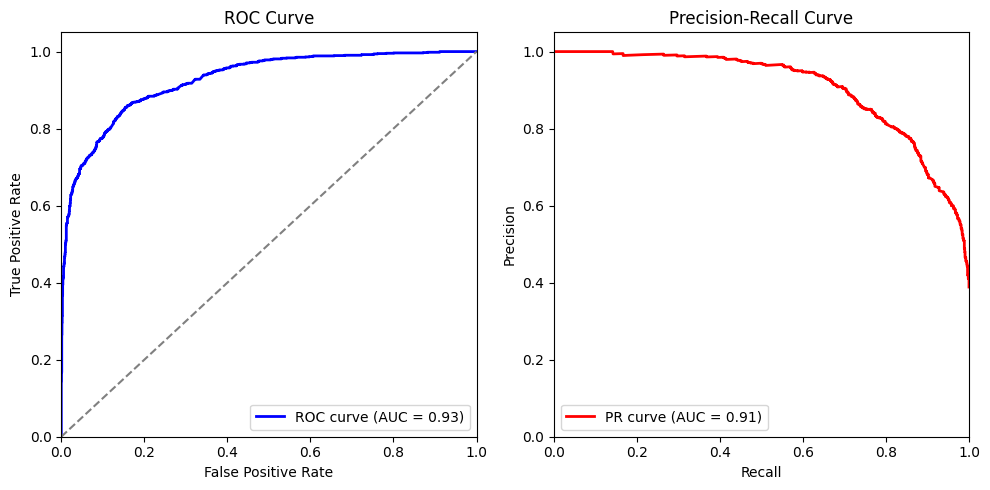

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Estratificación para validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones usando validación cruzada
y_pred_prob = cross_val_predict(eclf1, X, y, cv=cv, method='predict_proba')

# Tomar las probabilidades de la clase positiva
y_scores = y_pred_prob[:, 1]  # Asumiendo que la clase positiva está en la columna 1

# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Calcular curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y, y_scores)
pr_auc = average_precision_score(y, y_scores)

# Graficar curva ROC
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Graficar curva PR
plt.subplot(1,2,2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


### NutrientDataset

In [13]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## -------------------------
## Define features and target (use df_resampled5c here; swap for df_resampled5a to compare)
## -------------------------
X = df_resampled5c.drop('Diabetes', axis=1)
y = df_resampled5c['Diabetes']

## Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

## -------------------------
## Base learners with tuned hyperparameters
## Note: LightGBM 'subsample' (bagging_fraction) requires bagging_freq > 0 to take effect.
## -------------------------
clf1 = xgb.XGBClassifier(
    subsample=0.6111111111111112,
    n_estimators=490,
    min_child_weight=1,
    max_depth=10,
    learning_rate=0.05578947368421053,
    gamma=0.0,
    colsample_bytree=0.6111111111111112,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

clf2 = lgb.LGBMClassifier(
    subsample=0.7749999999999999,
    n_estimators=475,
    min_child_weight=1,
    max_depth=7,
    learning_rate=0.1,
    colsample_bytree=0.85,
    verbose=-1,
    force_col_wise=True,
    bagging_freq=1,     ## ensure 'subsample' is applied
    random_state=42
)

clf3 = CatBoostClassifier(
    subsample=0.7749999999999999,
    learning_rate=0.09000000000000001,
    iterations=450,
    depth=9,
    colsample_bylevel=0.925,
    verbose=0,
    random_state=42
)

clf4 = RandomForestClassifier(
    n_estimators=350,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=50,
    bootstrap=False,
    random_state=42
)

clf5 = KNeighborsClassifier(
    weights='uniform',
    n_neighbors=1,
    metric='manhattan'
)

## -------------------------
## Soft-voting ensemble (probability averaging)
## -------------------------
eclf1 = VotingClassifier(
    estimators=[('xgb', clf1), ('lgbm', clf2), ('catb', clf3), ('rf', clf4), ('knn', clf5)],
    voting='soft',
    n_jobs=None  ## keep CPU usage controlled; adjust if needed
)

## Fit ensemble
eclf1.fit(X_train, y_train)

## Predict on test split
y_pred_ensemble = eclf1.predict(X_test)

## Metrics (binary, fixed label order to ensure 2x2 confusion matrix)
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble, labels=[0, 1])
tn, fp, fn, tp = cm_ensemble.ravel()

accuracy_ensemble  = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='binary', zero_division=0)
recall_ensemble    = recall_score(y_test, y_pred_ensemble, average='binary', zero_division=0)
f1_ensemble        = f1_score(y_test, y_pred_ensemble, average='binary', zero_division=0)

print("Ensemble Model — Test Metrics")
print(f"  Accuracy:  {accuracy_ensemble:.4f}")
print(f"  Precision: {precision_ensemble:.4f}")
print(f"  Recall:    {recall_ensemble:.4f}")
print(f"  F1 Score:  {f1_ensemble:.4f}")
print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

## -------------------------
## Cross-validated F1 (stratified 5-fold by default for classifiers)
## -------------------------
cv_scores = cross_val_score(eclf1, X, y, cv=5, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f}")


Ensemble Model — Test Metrics
  Accuracy:  0.9129
  Precision: 0.9004
  Recall:    0.8703
  F1 Score:  0.8851
  Confusion Matrix: TN=358, FP=23, FN=31, TP=208
Cross-validated F1 scores: [0.89552239 0.88842975 0.88888889 0.87280702 0.89640592]
Mean CV F1: 0.8884


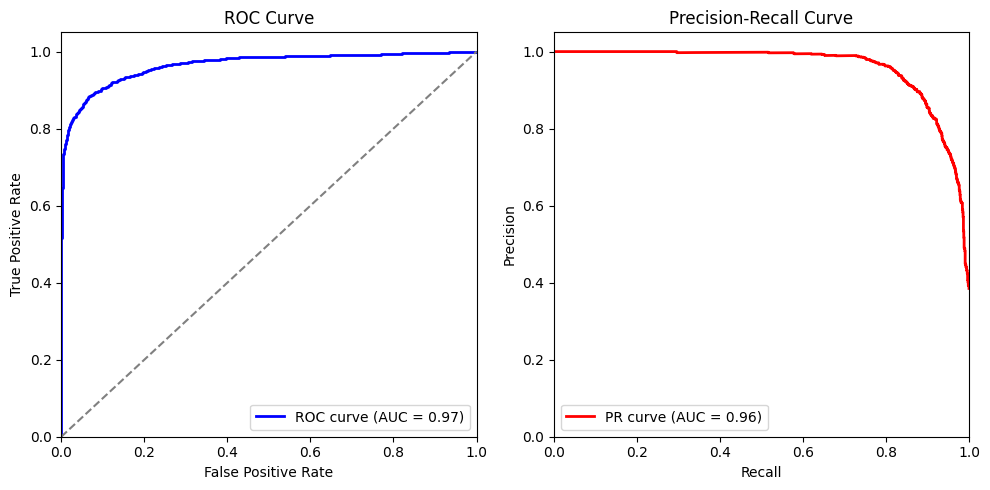

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Estratificación para validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones usando validación cruzada
y_pred_prob = cross_val_predict(eclf1, X, y, cv=cv, method='predict_proba')

# Tomar las probabilidades de la clase positiva
y_scores = y_pred_prob[:, 1]  # Asumiendo que la clase positiva está en la columna 1

# Calcular curva ROC y AUC
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Calcular curva de Precisión-Recall y AUC
precision, recall, _ = precision_recall_curve(y, y_scores)
pr_auc = average_precision_score(y, y_scores)

# Graficar curva ROC
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Graficar curva PR
plt.subplot(1,2,2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


## Step 7 – Model Performance Comparison (Statistical Tests)

Compare the ensemble against each tuned single model across paired CV folds using:

• Paired t-test (mean difference across folds),

• Wilcoxon signed-rank (non-parametric),

• Plus the mean difference (Ensemble − Model) and a 95% CI.

In [15]:
from scipy.stats import ttest_rel, wilcoxon, t as t_dist
import numpy as np

## Metrics compared fold-by-fold
metrics = ["Accuracy", "Precision", "Recall", "F1"]

## ── Replace these with your real CV scores (per fold) ─────────────────────────
scores_ensemble = {
    "Accuracy": [0.93548387, 0.94516129, 0.93225806, 0.95806452, 0.93548387, 0.95806452, 0.94174757, 0.92880259, 0.96116505, 0.9223301],
    "Precision": [0.93103448, 0.94017094, 0.89516129, 0.94915254, 0.90909091, 0.94915254, 0.94690265, 0.93693694, 0.97345133, 0.89915966],
    "Recall": [0.9, 0.91666667, 0.93277311, 0.94117647, 0.92436975, 0.94117647, 0.89915966, 0.87394958, 0.92436975, 0.89915966],
    "F1": [0.91525424, 0.92827004, 0.91358025, 0.94514768, 0.91666667, 0.94514768, 0.92241379, 0.90434783, 0.94827586, 0.89915966]
}

models = {
    "XGB": {
        "Accuracy": [0.88387097, 0.92258065, 0.91612903, 0.92258065, 0.91612903, 0.92903226, 0.90938511, 0.90291262, 0.94498382, 0.88673139],
        "Precision": [0.88181818, 0.94444444, 0.8907563, 0.92035398, 0.8907563, 0.93693694, 0.90990991, 0.93203883, 0.93965517, 0.86206897],
        "Recall": [0.80833333, 0.85, 0.8907563, 0.87394958, 0.8907563, 0.87394958, 0.8487395, 0.80672269, 0.91596639, 0.84033613],
        "F1": [0.84347826, 0.89473684, 0.8907563, 0.89655172, 0.8907563, 0.90434783, 0.87826087, 0.86486486, 0.92765957, 0.85106383]
    },
    "LightGBM": {
        "Accuracy": [0.88709677, 0.92580645, 0.89677419, 0.91612903, 0.90322581, 0.9, 0.90614887, 0.88996764, 0.93203883, 0.87378641],
        "Precision": [0.88288288, 0.93693694, 0.8372093, 0.8974359, 0.856, 0.84920635, 0.91666667, 0.88990826, 0.90163934, 0.83333333],
        "Recall": [0.81666667, 0.86666667, 0.90756303, 0.88235294, 0.89915966, 0.89915966, 0.83193277, 0.81512605, 0.92436975, 0.84033613],
        "F1": [0.84848485, 0.9004329, 0.87096774, 0.88983051, 0.87704918, 0.87346939, 0.8722467, 0.85087719, 0.91286307, 0.83682008]
    },
    "CatBoost": {
        "Accuracy": [0.91935484, 0.93225806, 0.92903226, 0.91935484, 0.92580645, 0.92580645, 0.93203883, 0.91262136, 0.9579288, 0.90291262],
        "Precision": [0.90598291, 0.94594595, 0.888, 0.90517241, 0.90677966, 0.92105263, 0.96226415, 0.91071429, 0.95689655, 0.88034188],
        "Recall": [0.88333333, 0.875, 0.93277311, 0.88235294, 0.89915966, 0.88235294, 0.85714286, 0.85714286, 0.93277311, 0.86554622],
        "F1": [0.89451477, 0.90909091, 0.90983607, 0.89361702, 0.90295359, 0.90128755, 0.90666667, 0.88311688, 0.94468085, 0.87288136]
    },
    "RandomForest": {
        "Accuracy": [0.89032258, 0.92903226, 0.92258065, 0.91290323, 0.91935484, 0.91612903, 0.91585761, 0.88673139, 0.94498382, 0.89967638],
        "Precision": [0.93, 0.97115385, 0.92792793, 0.96938776, 0.94339623, 0.95145631, 0.96969697, 0.92, 0.98113208, 0.92307692],
        "Recall": [0.775, 0.84166667, 0.86554622, 0.79831933, 0.84033613, 0.82352941, 0.80672269, 0.77310924, 0.87394958, 0.80672269],
        "F1": [0.84545455, 0.90178571, 0.89565217, 0.87557604, 0.88888889, 0.88288288, 0.88073394, 0.84018265, 0.92444444, 0.86098655]
    },
    "KNN": {
        "Accuracy": [0.76510067, 0.73825503, 0.79530201, 0.7885906, 0.74410774, 0.75420875, 0.75084175, 0.78114478, 0.76094276, 0.73737374],
        "Precision": [0.6402439, 0.61046512, 0.68965517, 0.65868263, 0.61363636, 0.63030303, 0.62893082, 0.65822785, 0.63253012, 0.60451977],
        "Recall": [0.90517241, 0.90517241, 0.86206897, 0.94827586, 0.93103448, 0.89655172, 0.86956522, 0.90434783, 0.91304348, 0.93043478],
        "F1": [0.75, 0.72916667, 0.76628352, 0.77738516, 0.73972603, 0.74021352, 0.72992701, 0.76190476, 0.74733096, 0.73287671]
    }
}
## ─────────────────────────────────────────────────────────────────────────────

def summarize_pair(ens_scores, model_scores, metric_name, alpha=0.05):
    """Paired tests + mean difference and 95% CI."""
    ens = np.asarray(ens_scores, dtype=float)
    mod = np.asarray(model_scores, dtype=float)

    ## Basic checks
    if ens.shape != mod.shape:
        raise ValueError(f"[{metric_name}] Fold-length mismatch: ensemble={ens.shape}, model={mod.shape}")
    n = ens.size
    diff = ens - mod
    mean_diff = diff.mean()
    sd = diff.std(ddof=1) if n > 1 else np.nan
    se = sd / np.sqrt(n) if n > 1 else np.nan

    ## Two-sided paired t-test
    t_stat, p_two = ttest_rel(ens, mod, nan_policy="raise")

    ## 95% CI for mean difference (t distribution)
    if n > 1 and np.isfinite(se):
        tcrit = t_dist.ppf(1 - 0.5 * (1 - 0.95), df=n - 1)  # two-sided 95%
        ci_low = mean_diff - tcrit * se
        ci_high = mean_diff + tcrit * se
    else:
        ci_low = ci_high = np.nan

    ## Wilcoxon (two-sided); handle zero-diff edge cases
    try:
        w_stat, p_wil = wilcoxon(ens, mod, zero_method="wilcox", alternative="two-sided", correction=False)
    except ValueError:
        w_stat, p_wil = np.nan, np.nan  # all diffs zero or invalid input

    ## One-sided interpretation (is Ensemble better?)
    better_t = (p_two / 2 < alpha) and (mean_diff > 0)
    better_w = (p_wil / 2 < alpha) and (mean_diff > 0) if np.isfinite(p_wil) else False

    print(f"\n{metric_name}:")
    print(f"  Paired t-test: t={t_stat:.3f}, p(two-sided)={p_two:.5f}")
    print(f"  Wilcoxon signed-rank: W={w_stat}, p(two-sided)={p_wil:.5f}")
    print(f"  Mean difference (Ensemble − Model): {mean_diff:.4f}  |  95% CI [{ci_low:.4f}, {ci_high:.4f}]")
    if better_t:
        print("  → Significant by t-test: Ensemble is better (one-sided).")
    else:
        print("  → No sufficient evidence by t-test (one-sided for Ensemble>Model).")
    if better_w:
        print("  → Significant by Wilcoxon: Ensemble is better (one-sided).")
    else:
        print("  → No sufficient evidence by Wilcoxon (one-sided for Ensemble>Model).")

## ── Run comparisons: Ensemble vs each model across all metrics ───────────────
for model_name, model_scores in models.items():
    print(f"\n=== ENSEMBLE vs {model_name} ===")
    for metric in metrics:
        summarize_pair(scores_ensemble[metric], model_scores[metric], metric)



=== ENSEMBLE vs XGB ===

Accuracy:
  Paired t-test: t=8.209, p(two-sided)=0.00002
  Wilcoxon signed-rank: W=0.0, p(two-sided)=0.00195
  Mean difference (Ensemble − Model): 0.0284  |  95% CI [0.0206, 0.0363]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

Precision:
  Paired t-test: t=3.985, p(two-sided)=0.00318
  Wilcoxon signed-rank: W=1.0, p(two-sided)=0.00391
  Mean difference (Ensemble − Model): 0.0221  |  95% CI [0.0096, 0.0347]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

Recall:
  Paired t-test: t=7.607, p(two-sided)=0.00003
  Wilcoxon signed-rank: W=0.0, p(two-sided)=0.00195
  Mean difference (Ensemble − Model): 0.0553  |  95% CI [0.0389, 0.0718]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

F1:
  Paired t-test: t=8.240, p(two-sided)=0.00002
  Wilcoxon sign

/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:134: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=-1)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:135: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=-1)



Recall:
  Paired t-test: t=6.094, p(two-sided)=0.00018
  Wilcoxon signed-rank: W=0.0, p(two-sided)=0.00391
  Mean difference (Ensemble − Model): 0.0469  |  95% CI [0.0295, 0.0644]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

F1:
  Paired t-test: t=11.274, p(two-sided)=0.00000
  Wilcoxon signed-rank: W=0.0, p(two-sided)=0.00195
  Mean difference (Ensemble − Model): 0.0505  |  95% CI [0.0404, 0.0607]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

=== ENSEMBLE vs CatBoost ===

Accuracy:
  Paired t-test: t=4.409, p(two-sided)=0.00170
  Wilcoxon signed-rank: W=0.0, p(two-sided)=0.00195
  Mean difference (Ensemble − Model): 0.0161  |  95% CI [0.0079, 0.0244]
  → Significant by t-test: Ensemble is better (one-sided).
  → Significant by Wilcoxon: Ensemble is better (one-sided).

Precision:
  Paired t-test: t=2.622, p(two-sided)=0.02770
  Wilcoxo

## Step 8 – Model Interpretation (Multi-sampling SHAP, Ensemble-Level)

Compute SHAP on multiple resampled splits to stabilize feature rankings and directionality.
Loop over n_iterations: balance data (SMOTE + undersampling), train tuned tree models (XGB, LGBM, CatBoost, RF), compute SHAP on the test fold, average SHAP across models to get an ensemble attribution, and aggregate per-feature statistics (frequency in Top-N, mean rank, mean |SHAP|, signed mean, sign of association, and median-based SHAP color ratios).

In [8]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1 ## Required for online environments with compatibility issues.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 82.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.14.0
    Uninstalling imbalanced-learn-0.14.0:
      Successfully uninstalled imbalanced-learn-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [4]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import shap

def _get_pos_class_shap(explainer, X):
    """
    Return SHAP values for the positive class as (n_samples, n_features),
    robust across SHAP versions/model APIs.
    """
    vals = explainer.shap_values(X)
    # SHAP may return: list (per class), 2D array, or 3D array.
    if isinstance(vals, list):
        # Binary: pick class 1 if available, else the last.
        return vals[1] if len(vals) > 1 else vals[0]
    vals = np.asarray(vals)
    if vals.ndim == 3 and vals.shape[1] == 2:
        # (n_samples, n_classes, n_features)
        return vals[:, 1, :]
    return vals  # (n_samples, n_features)

def run_shap_multisampling(
    df_original,
    target_column='Diabetes',
    n_iterations=10,
    top_n=15,
    random_seed=42
):
    """
    Multi-sampling SHAP procedure:
      1) Balance with SMOTE (+ undersampling majority to 1/3).
      2) Train tuned tree models (XGB, LGBM, CatBoost, RF).
      3) Compute SHAP on the test split; average SHAP across models.
      4) Aggregate Top-N features and directionality metrics across iterations.
    Returns a summary DataFrame sorted by frequency in Top-N.
    """
    np.random.seed(random_seed)

    top_features_per_iteration = []
    signed_features_per_iteration = []

    # For median-based "red/blue" ratios
    feature_ratios_above_blue = defaultdict(list)
    feature_ratios_above_red = defaultdict(list)
    feature_ratios_below_blue = defaultdict(list)
    feature_ratios_below_red = defaultdict(list)

    # Store per-iteration data needed for later aggregation (correlations)
    shap_ensemble_per_iter = []
    X_test_per_iter = []

    for i in range(n_iterations):
        print(f"\nIteration {i+1}/{n_iterations}...")

        # --------------------
        # SMOTE + undersampling
        # --------------------
        X = df_original.drop(target_column, axis=1)
        y = df_original[target_column]

        class_counts = y.value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        max_minority_samples = int(class_counts[minority_class] * 4)
        sampling_strategy = {
            majority_class: class_counts[majority_class],
            minority_class: max_minority_samples
        }

        # Keep your k_neighbors=5 (as specified)
        smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=np.random.randint(0, 10_000))
        X_resampled, y_resampled = smote.fit_resample(X, y)

        df_temp = pd.concat([
            pd.DataFrame(X_resampled, columns=X.columns),
            pd.Series(y_resampled, name=target_column)
        ], axis=1)

        majority_count_after_smote = df_temp[df_temp[target_column] == majority_class].shape[0]
        # Keep /3 as you required
        majority_count_target = int(majority_count_after_smote / 3)

        df_majority = df_temp[df_temp[target_column] == majority_class].sample(
            majority_count_target, random_state=np.random.randint(0, 10_000)
        )
        df_minority = df_temp[df_temp[target_column] == minority_class]
        df_resampled = pd.concat([df_majority, df_minority], axis=0).sample(frac=1, random_state=np.random.randint(0, 10_000)).reset_index(drop=True)

        # --------------------
        # Train ensemble models (tuned hyperparameters kept)
        # --------------------
        X = df_resampled.drop(target_column, axis=1)
        y = df_resampled[target_column]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=np.random.randint(0, 10_000)
        )

        clf_xgb = xgb.XGBClassifier(
            subsample=0.6111, n_estimators=490, min_child_weight=1,
            max_depth=10, learning_rate=0.0558, gamma=0.0,
            colsample_bytree=0.6111, eval_metric='logloss', random_state=random_seed, verbosity=0
        )
        clf_lgb = lgb.LGBMClassifier(
            subsample=0.775, n_estimators=475, min_child_weight=1,
            max_depth=7, learning_rate=0.1, colsample_bytree=0.85,
            random_state=random_seed, verbose=-1, force_col_wise=True, bagging_freq=1
        )
        clf_cat = CatBoostClassifier(
            subsample=0.775, learning_rate=0.09, iterations=450,
            depth=9, rsm=0.925, verbose=0, random_state=random_seed  # 'rsm' is CatBoost's column sampling
        )
        clf_rf = RandomForestClassifier(
            n_estimators=350, min_samples_split=2, min_samples_leaf=1,
            max_depth=50, bootstrap=False, random_state=random_seed
        )

        clf_xgb.fit(X_train, y_train)
        clf_lgb.fit(X_train, y_train)
        clf_cat.fit(X_train, y_train)
        clf_rf.fit(X_train, y_train)

        # --------------------
        # SHAP Values
        # --------------------
        ## Use TreeExplainer for tree models; aggregate positive-class SHAP
        explainer_xgb = shap.TreeExplainer(clf_xgb)
        explainer_lgb = shap.TreeExplainer(clf_lgb)
        explainer_cat = shap.TreeExplainer(clf_cat)
        explainer_rf  = shap.TreeExplainer(clf_rf)

        shap_xgb = _get_pos_class_shap(explainer_xgb, X_test)
        shap_lgb = _get_pos_class_shap(explainer_lgb, X_test)
        shap_cat = _get_pos_class_shap(explainer_cat, X_test)
        shap_rf  = _get_pos_class_shap(explainer_rf,  X_test)

        # Ensemble attribution by simple average across models
        shap_ensemble = (np.asarray(shap_xgb) + np.asarray(shap_lgb) + np.asarray(shap_cat) + np.asarray(shap_rf)) / 4.0

        # Rank features by mean absolute SHAP; keep signed mean for directionality
        mean_signed_shap = pd.Series(shap_ensemble.mean(axis=0), index=X_test.columns).sort_values(key=np.abs, ascending=False)
        mean_abs_shap    = pd.Series(np.abs(shap_ensemble).mean(axis=0), index=X_test.columns).sort_values(ascending=False)

        top_features = mean_abs_shap.head(top_n)
        top_signed   = mean_signed_shap[top_features.index]

        top_features_per_iteration.append(top_features)
        signed_features_per_iteration.append(top_signed)
        shap_ensemble_per_iter.append(shap_ensemble)
        X_test_per_iter.append(X_test.copy())

        # Median color ratios within the test split for Top-N
        for feature in top_features.index:
            shap_values_feature = shap_ensemble[:, X_test.columns.get_loc(feature)]

            above = shap_values_feature > 0  # SHAP > 0: pushes toward positive class
            below = ~above

            x_feature = X_test[feature]
            x_median = x_feature.median()

            reds_above  = (x_feature[above]  >  x_median).sum()
            blues_above = (x_feature[above]  <= x_median).sum()
            reds_below  = (x_feature[below]  >  x_median).sum()
            blues_below = (x_feature[below]  <= x_median).sum()

            total_above = reds_above + blues_above
            total_below = reds_below + blues_below

            if total_above > 0:
                feature_ratios_above_blue[feature].append(blues_above / total_above)
                feature_ratios_above_red[feature].append(reds_above / total_above)
            if total_below > 0:
                feature_ratios_below_blue[feature].append(blues_below / total_below)
                feature_ratios_below_red[feature].append(reds_below / total_below)

    # --------------------
    # Aggregate Results across iterations
    # --------------------
    feature_counter = Counter()
    feature_ranks = defaultdict(list)
    feature_shap_means = defaultdict(list)
    feature_signed_means = defaultdict(list)
    feature_correlations = defaultdict(list)

    for idx_iter, (abs_series, signed_series, shap_mat, Xtest_iter) in enumerate(
        zip(top_features_per_iteration, signed_features_per_iteration, shap_ensemble_per_iter, X_test_per_iter)
    ):
        for rank, (feature, abs_value) in enumerate(abs_series.items(), start=1):
            feature_counter[feature] += 1
            feature_ranks[feature].append(rank)
            feature_shap_means[feature].append(abs_value)
            feature_signed_means[feature].append(signed_series[feature])

            # Correlation between raw feature values and SHAP contribution in this iteration
            feat_idx = Xtest_iter.columns.get_loc(feature)
            xv = np.asarray(Xtest_iter[feature], dtype=float)
            sv = np.asarray(shap_mat[:, feat_idx], dtype=float)
            if np.std(xv) > 0 and np.std(sv) > 0:
                corr = np.corrcoef(xv, sv)[0, 1]
            else:
                corr = np.nan
            feature_correlations[feature].append(corr)

    # Build summary table
    mean_corr = {f: (np.nanmean(vals) if len(vals) else np.nan) for f, vals in feature_correlations.items()}
    df_summary = pd.DataFrame({
        "Feature": list(feature_counter.keys()),
        f"Times in Top {top_n}": [feature_counter[f] for f in feature_counter.keys()],
        "Average Rank": [np.mean(feature_ranks[f]) for f in feature_counter.keys()],
        "Mean |SHAP| Value": [np.mean(feature_shap_means[f]) for f in feature_counter.keys()],
        "Mean SHAP (signed)": [np.mean(feature_signed_means[f]) for f in feature_counter.keys()],
        "Mean Corr (X vs SHAP)": [mean_corr[f] for f in feature_counter.keys()],
        "Directional Trend": [
            "Higher values → Increase risk" if (mean_corr.get(f, 0) or 0) > 0 else "Higher values → Decrease risk"
            for f in feature_counter.keys()
        ],
        "Above Median SHAP (% Blue)": [round(100 * np.mean(feature_ratios_above_blue[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Blue) SD": [round(100 * np.std(feature_ratios_above_blue[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Red)": [round(100 * np.mean(feature_ratios_above_red[f]), 2) for f in feature_counter.keys()],
        "Above Median SHAP (% Red) SD": [round(100 * np.std(feature_ratios_above_red[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Blue)": [round(100 * np.mean(feature_ratios_below_blue[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Blue) SD": [round(100 * np.std(feature_ratios_below_blue[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Red)": [round(100 * np.mean(feature_ratios_below_red[f]), 2) for f in feature_counter.keys()],
        "Below Median SHAP (% Red) SD": [round(100 * np.std(feature_ratios_below_red[f]), 2) for f in feature_counter.keys()],
    }).sort_values(by=f"Times in Top {top_n}", ascending=False).reset_index(drop=True)

    print("\nSHAP multi-sampling summary ready.")
    return df_summary


### FoodDataset (3 interations test)

In [11]:
## Robust call for FoodDataset (df = EN2005a)
## Keep only numeric features + target, and drop rows with missing values
df_in = EN2005a.copy()

# Ensure target exists and is numeric/binary
assert 'Diabetes' in df_in.columns, "Column 'Diabetes' not found."

num_feats = df_in.drop(columns=['Diabetes']).select_dtypes(include='number').columns
df_for_shap = pd.concat([df_in[num_feats], df_in['Diabetes']], axis=1).dropna()

df_results_5a = run_shap_multisampling(
    df_original=df_for_shap,
    target_column='Diabetes',
    n_iterations=30,
    top_n=10,
    random_seed=42
)
print(df_results_5a)



Iteration 1/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Iteration 2/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Iteration 3/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



SHAP multi-sampling summary ready.
             Feature  Times in Top 10  Average Rank  Mean |SHAP| Value  \
0       Oils or fats                3      3.000000           0.311954   
1             Fruits                3      1.333333           0.355195   
2           Proteins                3      6.666667           0.267089   
3             Sweets                3      3.000000           0.318322   
4           Red meat                3      4.000000           0.308106   
5             Tubers                3      4.666667           0.291336   
6      Hot beverages                3      6.666667           0.263414   
7         White meat                3      9.333333           0.241504   
8         Vegetables                3      8.333333           0.251187   
9  Grain and cereals                3      8.000000           0.271443   

   Mean SHAP (signed)  Mean Corr (X vs SHAP)              Directional Trend  \
0            0.016988               0.419535  Higher values → Increase

### NutrientsDataset (3 interations test)

In [12]:
## Robust call for NutrientDataset (df = EN2005c)
df_in_c = EN2005c.copy()
assert 'Diabetes' in df_in_c.columns, "Column 'Diabetes' not found."

num_feats_c = df_in_c.drop(columns=['Diabetes']).select_dtypes(include='number').columns
df_for_shap_c = pd.concat([df_in_c[num_feats_c], df_in_c['Diabetes']], axis=1).dropna()

df_results_5c = run_shap_multisampling(
    df_original=df_for_shap_c,
    target_column='Diabetes',
    n_iterations=3,
    top_n=10,
    random_seed=42
)
print(df_results_5c)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f65c7831260>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error



Iteration 1/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Iteration 2/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Iteration 3/3...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



SHAP multi-sampling summary ready.
                           Feature  Times in Top 10  Average Rank  \
0                        Zinc (mg)                3      2.333333   
1                  Vitamin B6 (mg)                3      1.333333   
2                Vitamin A (µg RE)                3      2.666667   
3                  Crude Fiber (g)                3      5.333333   
4               Animal Protein (g)                3      8.666667   
5                 Cholesterol (mg)                2      5.500000   
6   Concentrated Carbohydrates (g)                2      6.000000   
7              Kilocalories (kcal)                2      7.500000   
8                   Potassium (mg)                2      8.500000   
9                  Folic Acid (µg)                2      7.000000   
10                  Magnesium (mg)                2      5.000000   
11                    Calcium (mg)                1      6.000000   
12                     Sodium (mg)                1      9.000000  

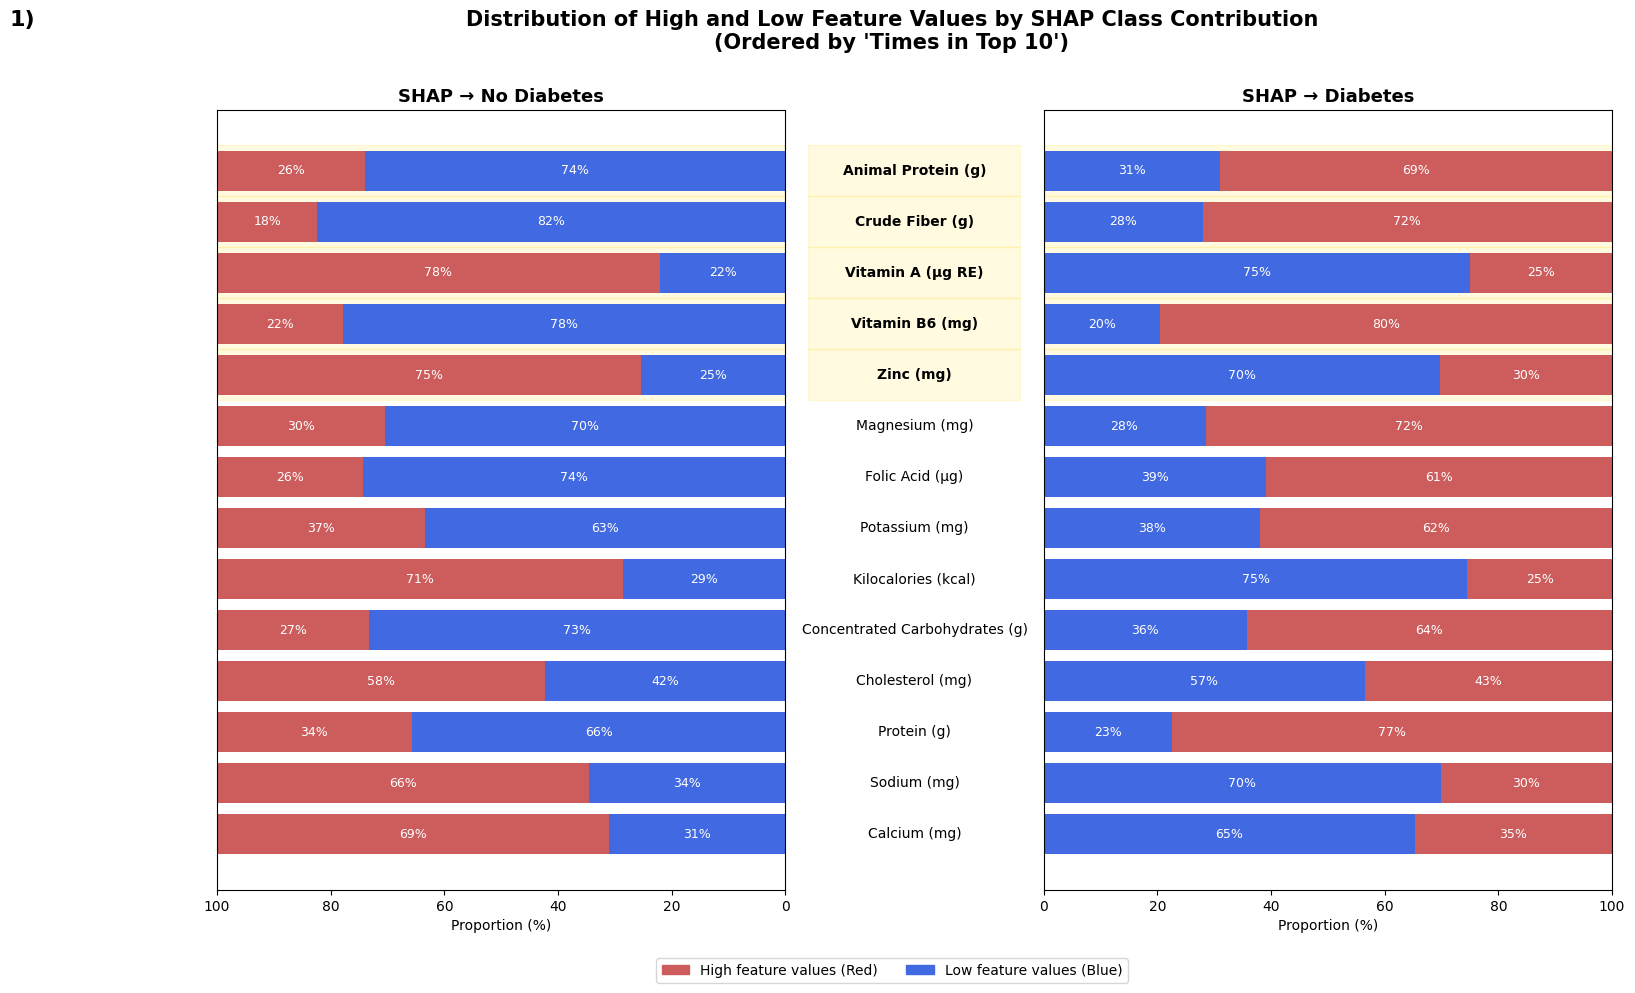

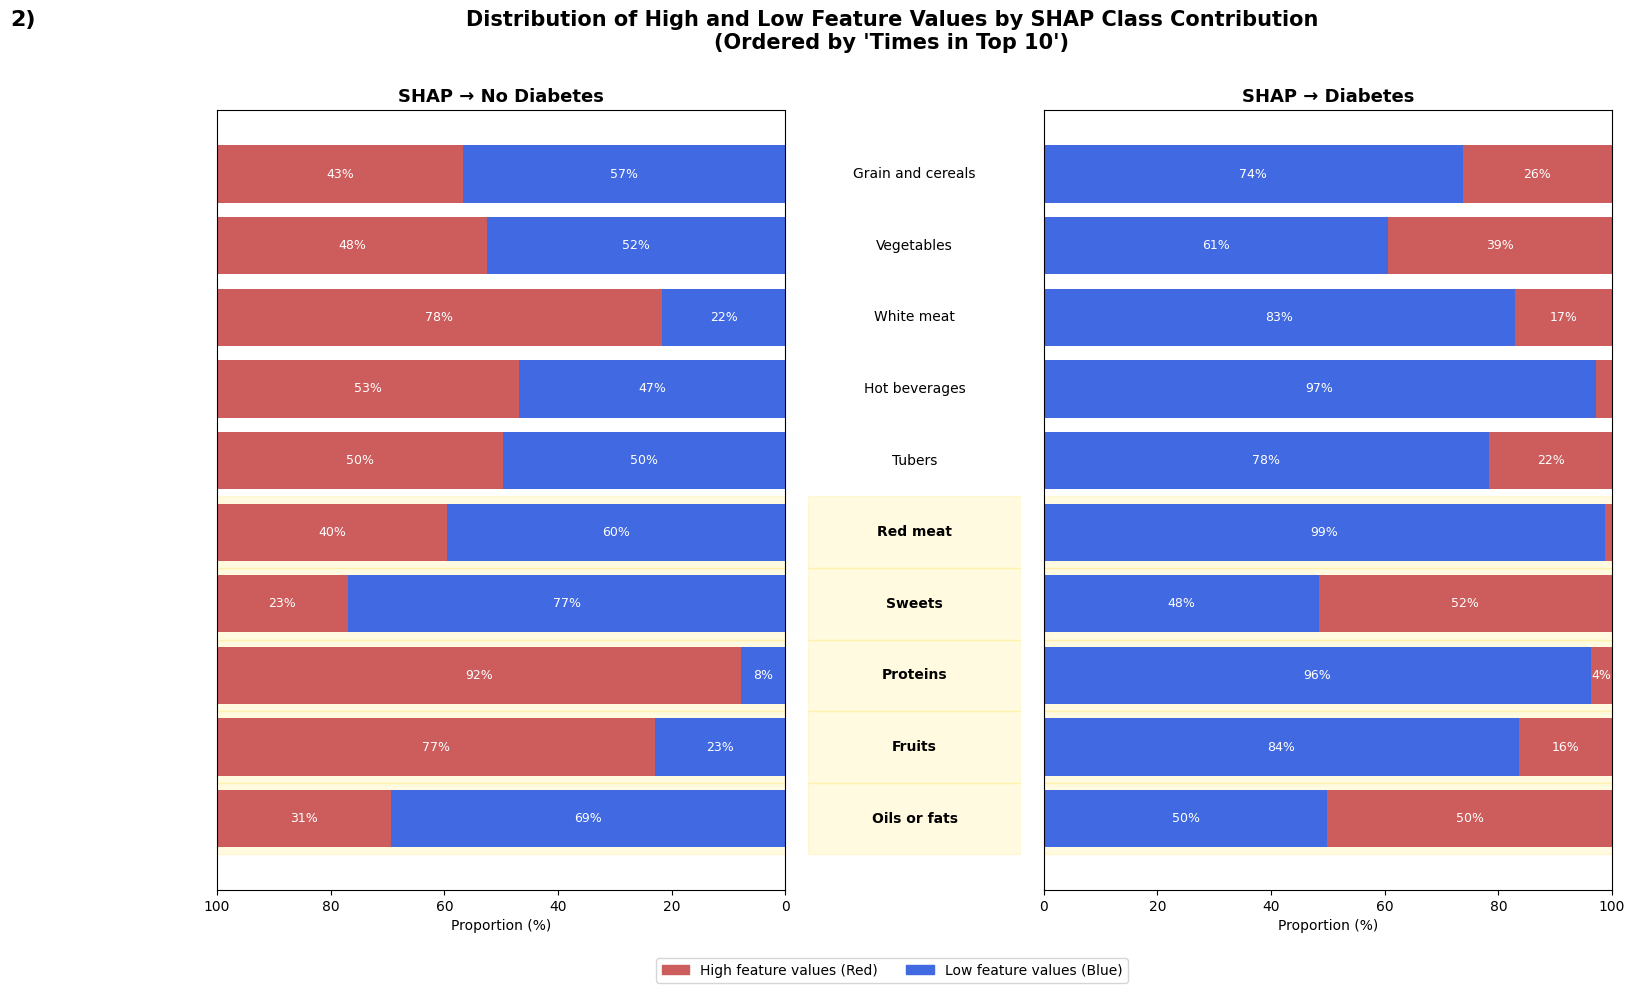

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import re

def _get_top10_col(df):
    """Return exact 'Times in Top 10' if present; otherwise detect 'Times in Top {N}'."""
    if 'Times in Top 10' in df.columns:
        return 'Times in Top 10'
    for c in df.columns:
        if isinstance(c, str) and c.startswith("Times in Top"):
            return c
    raise KeyError("No 'Times in Top 10' (or generic 'Times in Top {N}') column found.")

def plot_shap_stacked(summary_df, panel_label="1)"):
    """
    Plot stacked bars for SHAP ratios from run_shap_multisampling() summary.
    - Sorts by 'Times in Top 10' (or detected 'Times in Top {N}') BEFORE plotting.
    - Highlights Top-5 features (gold background + bold labels).
    - Adds panel label (e.g., '1)' or '2)') at top-left.
    - Legend: Red = High feature values, Blue = Low feature values.
    """
    col_top = _get_top10_col(summary_df)

    # Prepare plotting DF from the summary columns
    df_plot = pd.DataFrame({
        'Feature': summary_df['Feature'],
        col_top: summary_df[col_top],
        'Red → SHAP Diabetes': summary_df['Above Median SHAP (% Red)'],
        'Blue → SHAP Diabetes': summary_df['Above Median SHAP (% Blue)'],
        'Red → SHAP No Diabetes': summary_df['Below Median SHAP (% Red)'],
        'Blue → SHAP No Diabetes': summary_df['Below Median SHAP (% Blue)']
    })

    # --- Sort by Times in Top 10 BEFORE plotting ---
    # Keep ascending=True to match prior layout (small -> top, large -> bottom).
    df_plot = df_plot.sort_values(by=col_top, ascending=True).reset_index(drop=True)
    y_pos = range(len(df_plot))

    # Identify Top-5 (from unsorted ranking: highest frequency overall)
    top5_features = (summary_df.sort_values(by=col_top, ascending=False)['Feature'].head(5)).tolist()
    highlight_idx = [i for i, f in enumerate(df_plot['Feature']) if f in top5_features]

    # Colors and legend handles
    red_color  = 'indianred'   # High feature values
    blue_color = 'royalblue'   # Low feature values
    legend_handles = [
        patches.Patch(color=red_color,  label='High feature values (Red)'),
        patches.Patch(color=blue_color, label='Low feature values (Blue)')
    ]

    # Create figure with 3 columns
    fig, (ax1, ax_labels, ax2) = plt.subplots(
        ncols=3, sharey=True, figsize=(18, 10),
        gridspec_kw={'width_ratios': [4, 1.5, 4], 'wspace': 0.05}
    )

    # --- Left subplot: No Diabetes (SHAP < 0) ---
    blue_nd = df_plot['Blue → SHAP No Diabetes']
    red_nd  = df_plot['Red → SHAP No Diabetes']

    # Row highlights across axes
    for idx in highlight_idx:
        for ax in (ax1, ax_labels, ax2):
            ax.axhspan(idx - 0.5, idx + 0.5, color='gold', alpha=0.12, zorder=0)

    ax1.barh(y_pos, blue_nd, color=blue_color)
    ax1.barh(y_pos, red_nd,  left=blue_nd, color=red_color)
    ax1.set_xlim(100, 0)  # mirror scale
    ax1.set_title("SHAP → No Diabetes", fontsize=13, weight='bold')
    ax1.set_xlabel("Proportion (%)")
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([])

    for i, (blue, red) in enumerate(zip(blue_nd, red_nd)):
        if blue > 3:
            ax1.text(blue / 2, i, f"{blue:.0f}%", va='center', ha='center', color='white', fontsize=9)
        if red > 3:
            ax1.text(blue + red / 2, i, f"{red:.0f}%", va='center', ha='center', color='white', fontsize=9)

    # --- Middle labels subplot ---
    ax_labels.set_xlim(0, 1)
    ax_labels.set_xticks([])
    ax_labels.set_yticks([])
    ax_labels.set_frame_on(False)

    for i, label in enumerate(df_plot['Feature']):
        fw = 'bold' if i in highlight_idx else 'normal'
        ax_labels.text(0.5, i, label, va='center', ha='center', fontsize=10, fontweight=fw)

    # --- Right subplot: Diabetes (SHAP > 0) ---
    blue_d = df_plot['Blue → SHAP Diabetes']
    red_d  = df_plot['Red → SHAP Diabetes']

    ax2.barh(y_pos, blue_d, color=blue_color)
    ax2.barh(y_pos, red_d,  left=blue_d, color=red_color)
    ax2.set_xlim(0, 100)
    ax2.set_title("SHAP → Diabetes", fontsize=13, weight='bold')
    ax2.set_xlabel("Proportion (%)")
    ax2.set_yticks([])

    for i, (blue, red) in enumerate(zip(blue_d, red_d)):
        if blue > 3:
            ax2.text(blue / 2, i, f"{blue:.0f}%", va='center', ha='center', color='white', fontsize=9)
        if red > 3:
            ax2.text(blue + red / 2, i, f"{red:.0f}%", va='center', ha='center', color='white', fontsize=9)

    # Title, legend, and panel label
    fig.suptitle(
        "Distribution of High and Low Feature Values by SHAP Class Contribution\n(Ordered by 'Times in Top 10')",
        fontsize=15, weight='bold'
    )
    fig.legend(handles=legend_handles,
               loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0), fontsize=10)

    # Panel label (e.g., "1)" or "2)")
    fig.text(0.01, 0.98, panel_label, ha='left', va='top', fontsize=16, weight='bold')

    plt.subplots_adjust(bottom=0.10)
    # Save with TopN extracted if present
    m = re.search(r"Times in Top (\d+)", col_top)
    topN_str = m.group(1) if m else "10"
    plt.savefig(f"stacked_SHAP_Compounds_{panel_label.replace(')','')}_Top{topN_str}.png",
                dpi=250, bbox_inches='tight')
    plt.show()


# === Call for Nutrients (1) and Foods (2) ===
# Nutrients summary (e.g., summary_5c)
plot_shap_stacked(df_results_5c, panel_label="1)")

# Foods summary (e.g., summary_5a)
plot_shap_stacked(df_results_5a, panel_label="2)")
